# Scalable Bayesian Modeling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/symeneses/SBM/blob/main/notebooks/tennis.ipynb)

In [ ]:
# Execute only if executing in Google Colab
# !rm -r ./src
# !rm -r ./data
# !git clone https://github.com/symeneses/SBM
# !mv ./SBM/src ./src
# !mv ./SBM/data ./data
# !rm -r ./SBM
# !pip install --upgrade pip
# !pip install --upgrade numpyro==0.11.0 pymc==5.0.2 blackjax==0.9.6 seaborn

This use case is based on the Blog Post: [MCMC for big datasets](https://martiningram.github.io/mcmc-comparison/).

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

cores = os.cpu_count()
os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cores}'
root_path = os.path.abspath(os.pardir)
if root_path not in sys.path:
    sys.path.append(root_path)

## Importing the needed libraries

In [3]:
import pandas as pd
import numpy as np
import numpyro
import pymc as pm

from src.data import data_generator
from src.handler import Handler
from src.diagnostics import convergency_validator, dist_validator
from src.plots import plot_ess_ps, plot_monitor

pd.set_option('display.precision', 2)
RANDOM_SEED = 8957


/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniconda/base/envs/sbm/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Getting the data

Create a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the variables to be used to define the model.

✍🏽 User input required.

In [4]:
# Code to generate the data, name the final results as data
data = pd.read_csv("https://drive.google.com/uc?id=1KtkXe3_orIGCgP-_XE7tQdYWfqPzFTTF",
                   usecols=["tourney_date", "winner_name", "loser_name"],
                   parse_dates=['tourney_date'])
data["year"] = data["tourney_date"].dt.year

## Defining the model

In the following cells, write the code for the models you want to compare. To make comparing the models and results easier, use the same name of variables in each version of the model.

**For models in PyMC:** Create an annotated function, as in the example, that returns a `pm.model.Model`.

**For models in Numpyro:** Use the same variable names of the `DataFrame` `data` for the arguments of the function model. These arguments should contain only columns present in `data`.

✍🏽 User input required.

In [5]:

def pymc_model_gen(data: pd.DataFrame) -> pm.model.Model:
    _, players_map = (pd.concat([data["winner_name"], data["loser_name"]])).factorize()
    players = players_map.to_list()
    winners_codes = data["winner_name"].apply(lambda x: players.index(x)).values
    losers_codes = data["loser_name"].apply(lambda x: players.index(x)).values
    coords = {"players": np.arange(0, len(players))}
    with pm.Model(coords=coords) as pymc_model:
        # Your model here
        player_sd = pm.HalfNormal("player_sd", sigma=1.0)
        player_skills_raw = pm.Normal(
            "player_skills_raw", 0.0, sigma=1.0, dims="players")

        player_skills = pm.Deterministic("player_skills", player_skills_raw * player_sd)
        logit_skills = player_skills[winners_codes] - player_skills[losers_codes]

        lik = pm.Bernoulli(
            "win_lik", logit_p=logit_skills, observed=np.ones(winners_codes.shape[0])
        )
    return pymc_model

In [6]:
import numpyro.distributions as dist
from numpyro.infer import NUTS


def model(winner_name, loser_name):
    _, players_map = (pd.concat([winner_name, loser_name])).factorize()
    players = players_map.to_list()
    winners_codes = winner_name.apply(lambda x: players.index(x)).values
    losers_codes = loser_name.apply(lambda x: players.index(x)).values

    player_sd = numpyro.sample("player_sd", dist.HalfNormal(1.0))
    with numpyro.plate("players", len(players)):
        player_skills_raw = numpyro.sample("player_skills_raw", dist.Normal(0.0, 1.0))

    player_skills = numpyro.deterministic("player_skills", player_skills_raw * player_sd)
    logit_skills = player_skills[winners_codes] - player_skills[losers_codes]

    lik = numpyro.sample("win_lik", 
                         dist.BernoulliLogits(logit_skills),
                         obs=np.ones(winners_codes.shape[0]))

numpyro_kernel = NUTS(model)

## Inference
Here, we will create create valid [InferenceData](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.html) objects and a set of metrics to measure performance for the selected models, data sizes and samplers.

In [7]:
data.shape

(169073, 4)

### Creating multiple data sizes

To have a benchmark using different data sizes, we will use the function `data_generator` which will use the original dataset to generate datasets with the given `sizes` or filtering the original data in the parameter `filters`. You can also add Gaussian noise to selected variables using the parameter `include_noise`.

✍🏽 User input required.

In [8]:
data_sizes = []
include_noise = []
years = [2020, 2019, 2015, 2010, 2000, 1990, 1980, 1968]
filters = [f"year >= {y}" for y in years]
datasets = data_generator(data, filters=filters)
# If you want to work only with the original data, use this instead
# datasets = {"original_size": data}

In [9]:
data_sizes = [int(k) for k in datasets.keys()]
data_sizes

[6744, 9215, 19551, 32337, 60363, 93549, 126960, 169073]

### Sampling

⚠️ You should at least use 2 chains to be able to calculate correctly the diagnostics.

✍🏽 User input required.

In [10]:
# Use the following path if working in Google Colab
# output_path = "data/results"
output_path = "../data/results"
models = {"pymc": pymc_model_gen, "numpyro": numpyro_kernel}
pymc_samplers = ["default", "numpyro", "blackjax"]
draws = 2000
tune = 2000
# It's recommended to use between 2 and 4 chains
chains = 2

# sampling all models
handler = Handler(models, datasets, pymc_samplers, output_path)
infer_data, results = handler.execute(draws, tune, chains, RANDOM_SEED)


> Getting samples using libray pymc:

>> Getting samples for data with size 6744

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.450828
Sampling...
Sampling time =  0:00:18.792280
Transforming variables...
Transformation time =  0:00:00.121731

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.390168
Sampling...
Sampling time =  0:00:07.221611
Transforming variables...
Transformation time =  0:00:12.827142

>> Getting samples for data with size 9215

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.418282
Sampling...
Sampling time =  0:00:23.572639
Transforming variables...
Transformation time =  0:00:00.080787

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.422533
Sampling...
Sampling time =  0:00:07.340068
Transforming variables...
Transformation time =  0:00:17.077915

>> Getting samples for data with size 19551

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.434117
Sampling...
Sampling time =  0:00:48.211326
Transforming variables...
Transformation time =  0:00:00.082789

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.458951
Sampling...
Sampling time =  0:00:07.241691
Transforming variables...
Transformation time =  0:00:40.099102

>> Getting samples for data with size 32337

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 169 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.389388
Sampling...
Sampling time =  0:01:25.651531
Transforming variables...
Transformation time =  0:00:00.082818

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.367815
Sampling...
Sampling time =  0:00:07.304435
Transforming variables...
Transformation time =  0:01:15.549074

>> Getting samples for data with size 60363

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 304 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.454726
Sampling...
Sampling time =  0:02:55.096234
Transforming variables...
Transformation time =  0:00:00.089601

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.437726
Sampling...
Sampling time =  0:00:07.317296
Transforming variables...
Transformation time =  0:02:32.549825

>> Getting samples for data with size 93549

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 480 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.453920
Sampling...
Sampling time =  0:06:13.368562
Transforming variables...
Transformation time =  0:00:00.097417

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.414091
Sampling...
Sampling time =  0:00:07.139374
Transforming variables...
Transformation time =  0:03:08.308562

>> Getting samples for data with size 126960

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 650 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.461068
Sampling...
Sampling time =  0:05:56.315970
Transforming variables...
Transformation time =  0:00:00.092378

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.417574
Sampling...
Sampling time =  0:00:07.168837
Transforming variables...
Transformation time =  0:04:37.266973

>> Getting samples for data with size 169073

>>> Getting samples using the PYMC sampler default


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_sd, player_skills_raw]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1306 seconds.



>>> Getting samples using the PYMC sampler numpyro
Compiling...
Compilation time =  0:00:02.817461
Sampling...
Sampling time =  0:08:26.040209
Transforming variables...
Transformation time =  0:00:00.117647

>>> Getting samples using the PYMC sampler blackjax
Compiling...
Compilation time =  0:00:02.472225
Sampling...
Sampling time =  0:00:07.274715
Transforming variables...
Transformation time =  0:06:53.907569

> Getting samples using libray numpyro:

>> Getting samples for data with size 6744


Running chain 1: 100%|██████████| 4000/4000 [00:17<00:00, 233.97it/s]



>> Getting samples for data with size 9215


Running chain 1: 100%|██████████| 4000/4000 [00:21<00:00, 186.05it/s]



>> Getting samples for data with size 19551


Running chain 1: 100%|██████████| 4000/4000 [00:41<00:00, 95.66it/s] 



>> Getting samples for data with size 32337


Running chain 1: 100%|██████████| 4000/4000 [01:07<00:00, 58.98it/s]



>> Getting samples for data with size 60363


Running chain 1: 100%|██████████| 4000/4000 [02:22<00:00, 28.15it/s]



>> Getting samples for data with size 93549


Running chain 1: 100%|██████████| 4000/4000 [03:21<00:00, 19.88it/s]



>> Getting samples for data with size 126960


Running chain 1: 100%|██████████| 4000/4000 [04:52<00:00, 13.66it/s]



>> Getting samples for data with size 169073


Running chain 1: 100%|██████████| 4000/4000 [07:29<00:00,  8.89it/s]


## Check Convergency

After sampling, the function `convergency_validator` will help you know if the models have converged. This function use the [rank normalized splitR-hat](https://python.arviz.org/en/latest/api/generated/arviz.rhat.html).

An $\hat R$ > 1.05 indicates convergence failures. In this case, the results of the next step `Validate Results` **can't be considered** as they assumed the MCMC has converged. 

In [11]:
convergency_validator(infer_data)

Convergency test using R-hat:
> pymc_default_6744       : 1.01 ✅
> pymc_numpyro_6744       : 1.00 ✅
> pymc_blackjax_6744      : 1.01 ✅
> pymc_default_9215       : 1.01 ✅
> pymc_numpyro_9215       : 1.01 ✅
> pymc_blackjax_9215      : 1.01 ✅
> pymc_default_19551      : 1.01 ✅
> pymc_numpyro_19551      : 1.01 ✅
> pymc_blackjax_19551     : 1.01 ✅
> pymc_default_32337      : 1.01 ✅
> pymc_numpyro_32337      : 1.01 ✅
> pymc_blackjax_32337     : 1.01 ✅
> pymc_default_60363      : 1.01 ✅
> pymc_numpyro_60363      : 1.01 ✅
> pymc_blackjax_60363     : 1.01 ✅
> pymc_default_93549      : 1.01 ✅
> pymc_numpyro_93549      : 1.01 ✅
> pymc_blackjax_93549     : 1.01 ✅
> pymc_default_126960     : 1.01 ✅
> pymc_numpyro_126960     : 1.01 ✅
> pymc_blackjax_126960    : 1.01 ✅
> pymc_default_169073     : 1.01 ✅
> pymc_numpyro_169073     : 1.01 ✅
> pymc_blackjax_169073    : 1.01 ✅
> numpyro_default_6744    : 1.01 ✅
> numpyro_default_9215    : 1.01 ✅
> numpyro_default_19551   : 1.01 ✅
> numpyro_default_32337  

## Validate results 

To check that the models are sampling from the same distributions. The function `dist_validator` will estimate the ranges of the mean for each variable using the [MCSE](https://python.arviz.org/en/latest/api/generated/arviz.mcse.html) of one of the models as reference. You can either give a `seed` to choose a model randomly or give the key `ref_key` of a selected model. The reference model will be compared only with others using the same sample size.

The percentages displayed indicate how many variables are within the calculated range using ±3 sigma. The values should be in theory greater or equal to `95%` following a weaker [three-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In [12]:
results_val, summaries = dist_validator(infer_data, ref_key="pymc_numpyro_6744")

Percentage of variables with the expected mean using MCSE:
> pymc_default_6744       :  97.02% using as a reference pymc_numpyro_6744        ✅
> pymc_numpyro_6744       : 100.00% using as a reference pymc_numpyro_6744        ✅
> pymc_blackjax_6744      :  97.14% using as a reference pymc_numpyro_6744        ✅
> pymc_default_9215       :  97.24% using as a reference pymc_numpyro_9215        ✅
> pymc_numpyro_9215       : 100.00% using as a reference pymc_numpyro_9215        ✅
> pymc_blackjax_9215      :  98.30% using as a reference pymc_numpyro_9215        ✅
> pymc_default_19551      :  96.54% using as a reference pymc_numpyro_19551       ✅
> pymc_numpyro_19551      : 100.00% using as a reference pymc_numpyro_19551       ✅
> pymc_blackjax_19551     :  95.61% using as a reference pymc_numpyro_19551       ✅
> pymc_default_32337      :  95.24% using as a reference pymc_numpyro_32337       ✅
> pymc_numpyro_32337      : 100.00% using as a reference pymc_numpyro_32337       ✅
> pymc_blackjax_3

## Comparison

### Resources metrics

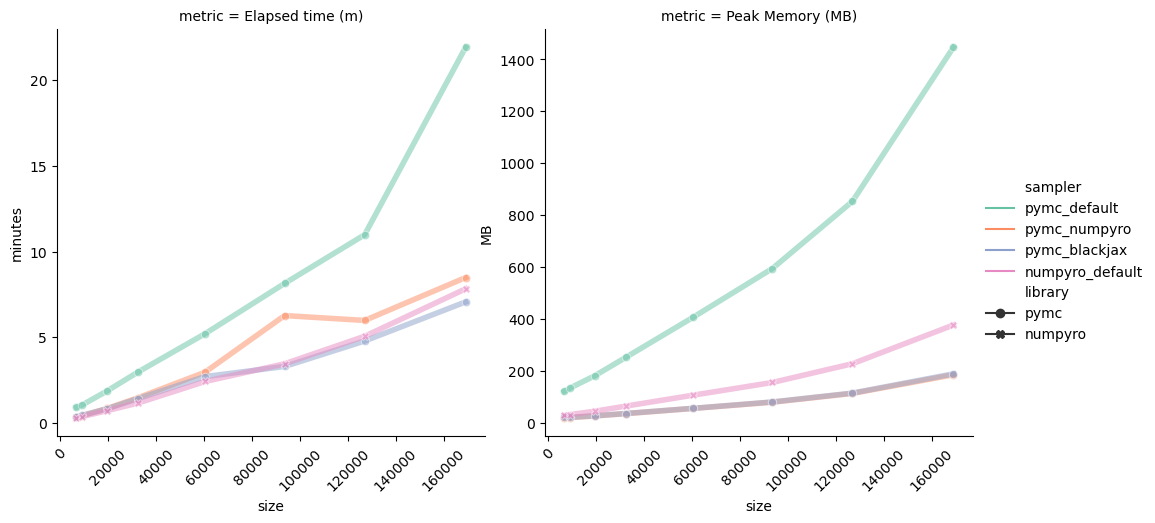

In [43]:
plot_monitor(results)

### ESS

To determine the sampler performance, we use the **Effective Sample Size** ([ESS](https://python.arviz.org/en/latest/api/generated/arviz.ess.html])) calculated per second.

Using 'ESS per Second' previously calculated


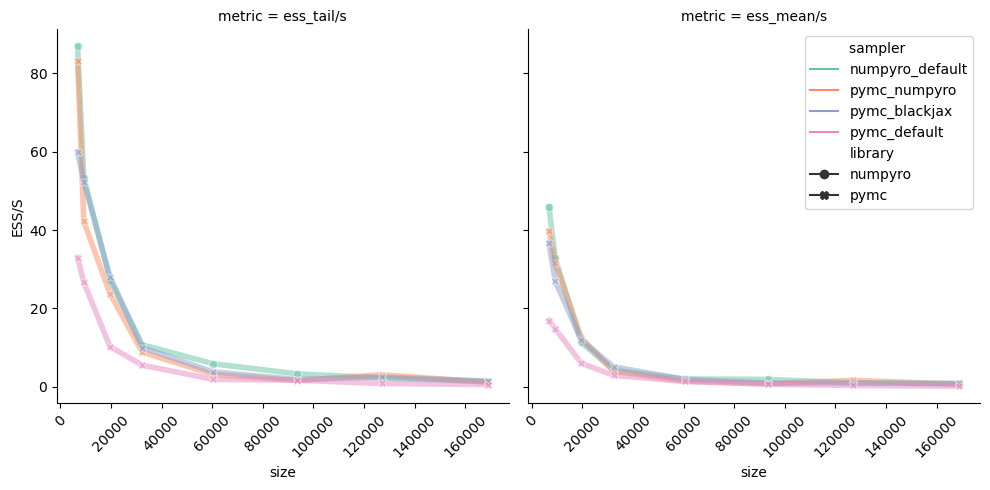

In [44]:
plot_ess_ps(results, summaries, data_sizes=data_sizes)

Using 'ESS per Second' previously calculated


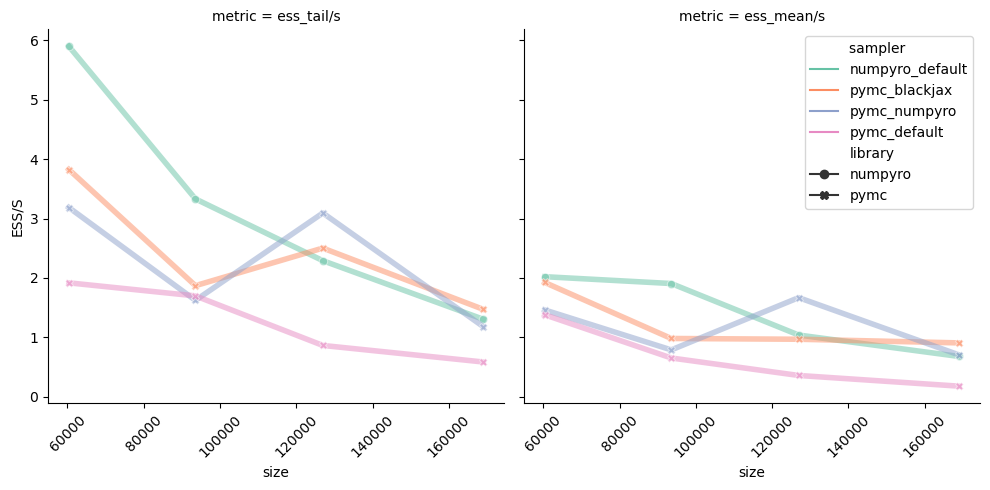

In [45]:
plot_ess_ps(results, summaries, data_sizes=data_sizes[-4:])

Using 'ESS per Second' previously calculated


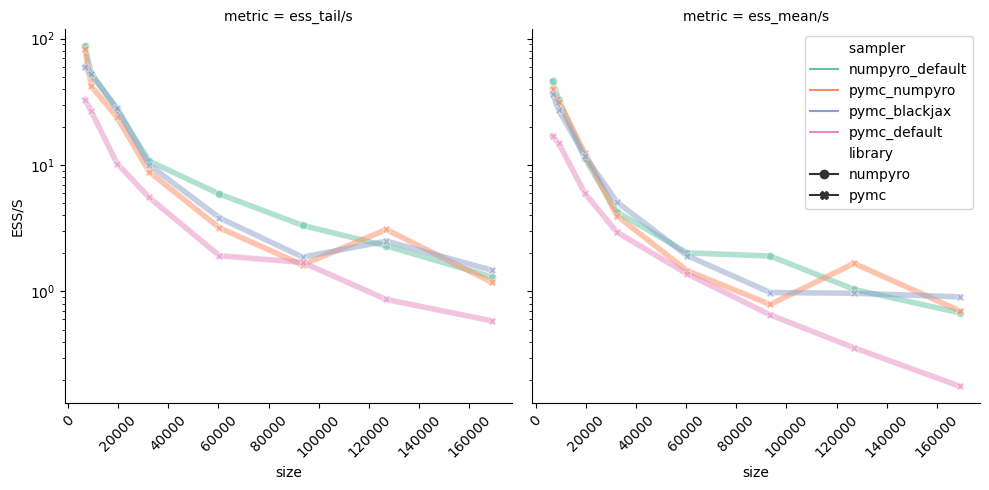

In [46]:
plot_ess_ps(results, summaries, data_sizes=data_sizes, log_scale="y")

Using 'ESS per Second' previously calculated


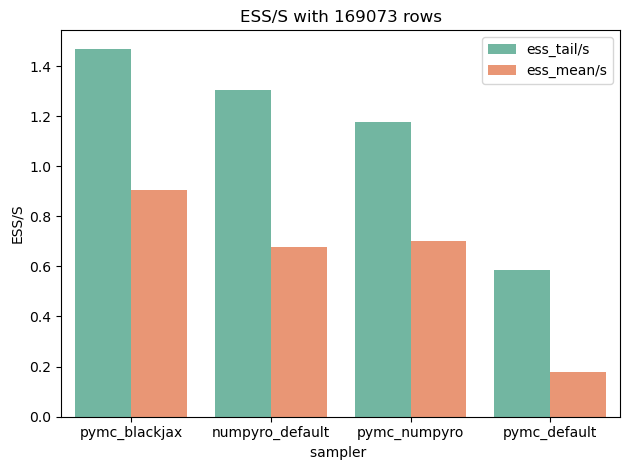

In [17]:
plot_ess_ps(results, summaries, data_sizes=[max(data_sizes)])

Let's rank the best across all data sizes:

In [18]:
summary = results.drop(columns=["current_memory", "peak_memory"])
summary["rank"] = summary.sort_values(["size", "ess_mean/s"], ascending=[True, False]) \
            .groupby(['size']) \
            .cumcount() + 1
summary.sort_values(["size", "rank"])

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_6744,numpyro,default,6744.0,18.77,30.61,0.31,45.89,86.90,1
pymc_numpyro_6744,pymc,numpyro,6744.0,21.48,22.07,0.36,39.73,83.15,2
pymc_blackjax_6744,pymc,blackjax,6744.0,22.76,23.71,0.38,36.63,59.93,3
pymc_default_6744,pymc,default,6744.0,55.01,123.22,0.92,16.93,32.98,4
numpyro_default_9215,numpyro,default,9215.0,22.79,34.07,0.38,32.84,53.36,1
pymc_numpyro_9215,pymc,numpyro,9215.0,26.13,22.52,0.44,31.71,42.25,2
pymc_blackjax_9215,pymc,blackjax,9215.0,26.92,23.19,0.45,27.02,52.41,3
pymc_default_9215,pymc,default,9215.0,63.62,136.32,1.06,14.84,26.70,4
pymc_numpyro_19551,pymc,numpyro,19551.0,50.80,28.64,0.85,12.49,23.82,1
pymc_blackjax_19551,pymc,blackjax,19551.0,49.90,29.24,0.83,11.88,28.07,2


Let's see the best options in each data size:

In [19]:
summary.query("rank == 1").sort_values("size")

,library,sampler,size,elapsed_time,Peak Memory (MB),Elapsed time (m),ess_mean/s,ess_tail/s,rank
numpyro_default_6744,numpyro,default,6744.0,18.77,30.61,0.31,45.89,86.90,1
numpyro_default_9215,numpyro,default,9215.0,22.79,34.07,0.38,32.84,53.36,1
pymc_numpyro_19551,pymc,numpyro,19551.0,50.80,28.64,0.85,12.49,23.82,1
pymc_blackjax_32337,pymc,blackjax,32337.0,85.23,38.00,1.42,5.11,10.03,1
numpyro_default_60363,numpyro,default,60363.0,145.31,108.34,2.42,2.02,5.90,1
numpyro_default_93549,numpyro,default,93549.0,207.22,157.35,3.45,1.91,3.33,1
pymc_numpyro_126960,pymc,numpyro,126960.0,358.93,115.38,5.98,1.67,3.09,1
pymc_blackjax_169073,pymc,blackjax,169073.0,423.77,190.67,7.06,0.91,1.47,1


## Results 

Let's visualize the tennis player skill estimates, as done in the original post. See *Addendum 1*.

In [20]:
key = "pymc_blackjax_169073"
_, players_map = (pd.concat([data["winner_name"], data["loser_name"]])).factorize()
mean_skill = infer_data["pymc_blackjax_169073"].posterior['player_skills'].mean(dim=('chain', 'draw'))
sd_skill = infer_data["pymc_blackjax_169073"].posterior['player_skills'].std(dim=('chain', 'draw'))
tennis = pd.DataFrame({'mean_skill': mean_skill, 'sd_skill': sd_skill}, index=players_map) \
    .       sort_values('mean_skill', ascending=False)

In [21]:
tennis.head(20)

,mean_skill,sd_skill
Novak Djokovic,3.60,0.09
Rafael Nadal,3.46,0.09
Bjorn Borg,3.42,0.11
Roger Federer,3.38,0.08
Ivan Lendl,3.35,0.08
Jimmy Connors,3.33,0.07
John McEnroe,3.33,0.09
Rod Laver,3.30,0.10
Pete Sampras,3.01,0.09
Boris Becker,2.93,0.09
